# Description of the problem: image processing with Thunder

This is the case study adopted from O'Reilly "Advanced analytics with Spark" book.
Thunder was designed specifically with neuroimaging datasets in mind. Thus, it is geared towards analysing large datasets of images captured over time.

## Zebrafish brains: the dataset

Let us load some plotting libraries and take a look at the example images from the dataset

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

The dataset consists of 20 76x87x2 pixel greyscale images.
Here is how the dataset looks like:

<img src="images/time015.tif">
<img src="images/time016.tif">

Typically, an image can be modeled as a 2D matrix of pixel each having value of the levels of grey (RGB images are somewhat different - they have multiple layers). Zebrafish brains are 3D objects, thus it is insuffient to just use 2D matrix (image), so a technique used to acquire different 2D images in different planes on top of each other (z-stack).

This produces 3D matrix of intensity values where each value represents a voxel (volume element).

## Loading the data into RDD

In [6]:
from thunder import ThunderContext
tsc = ThunderContext(sc)

In [8]:
# load some zebrafish brain data
imagesRDD = tsc.loadImages('./images', inputFormat='tif-stack')

# explore the resulting object
print imagesRDD
print imagesRDD.rdd
print imagesRDD.first()
print imagesRDD.first()[1].shape
print imagesRDD.dims

Images
nrecords: 20
dtype: None (inspect to compute)
shape: None (inspect to compute)
dims: None (inspect to compute)
PythonRDD[5] at RDD at PythonRDD.scala:43
(0, array([[[26, 25],
        [26, 25],
        [26, 25],
        ..., 
        [26, 26],
        [26, 26],
        [26, 26]],

       [[26, 25],
        [26, 25],
        [26, 25],
        ..., 
        [26, 26],
        [26, 26],
        [26, 26]],

       [[26, 26],
        [26, 26],
        [26, 26],
        ..., 
        [27, 26],
        [27, 26],
        [26, 26]],

       ..., 
       [[26, 26],
        [26, 26],
        [26, 26],
        ..., 
        [27, 26],
        [27, 26],
        [26, 26]],

       [[26, 26],
        [26, 26],
        [26, 26],
        ..., 
        [27, 26],
        [26, 26],
        [26, 26]],

       [[25, 25],
        [25, 25],
        [25, 25],
        ..., 
        [26, 26],
        [26, 26],
        [26, 26]]], dtype=uint8))
(76, 87, 2)
(76, 87, 2)


## Plot the raw and subsampled data

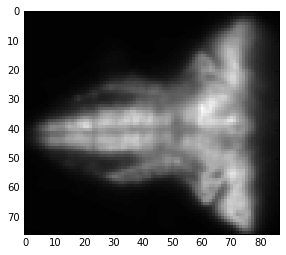

In [10]:
# plot the raw data
img = imagesRDD.values().first()
plt.imshow(img[:, : ,0], interpolation='nearest', aspect='equal', cmap='gray')

(16, 18, 2)


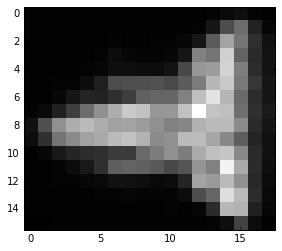

In [11]:
# plot subsampled data
subsampled = imagesRDD.subsample((5, 5, 1))
plt.imshow(subsampled.first()[1][:, : ,0], interpolation='nearest', aspect='equal', cmap='gray')
print subsampled.dims

## Series representation

The primary data types in Thunder are Images and Series. They can each be loaded from a variety of raw input formats, including text or flat binary files (for Series) and binary, tifs, or pngs (for Images). Given the stack of images, we can convert it to series adding an extra dimension.

In [12]:
# reshuffle data to series representation
seriesRDD = imagesRDD.toSeries()
print seriesRDD.dims
print seriesRDD.index
print seriesRDD.count()
print seriesRDD.rdd.takeSample(False, 1, 0)[0]
print seriesRDD.max()

(76, 87, 2)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
13224
((30, 0, 0), array([ 26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,
        26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.,  26.], dtype=float16))
[ 158.  152.  145.  143.  142.  141.  140.  140.  139.  139.  140.  140.
  142.  144.  153.  168.  179.  185.  185.  182.]


# Distributed computation of stats

In [13]:
stddevRDD = seriesRDD.seriesStdev()
print stddevRDD.take(3)
print stddevRDD.dims

[((0, 0, 0), 0.3999), ((1, 0, 0), 0.0), ((2, 0, 0), 0.0)]
(76, 87, 2)


<type 'numpy.ndarray'>
(76, 87, 2)


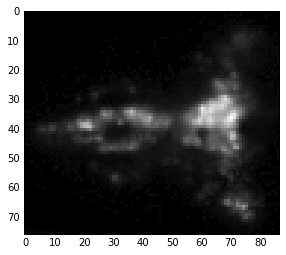

In [14]:
# collecting data locally and repacking it
repacked = stddevRDD.pack()
plt.imshow(repacked[:,:,0], interpolation='nearest', cmap='gray', aspect='equal')
print type(repacked)
print repacked.shape

# Plot some of the time series themselves

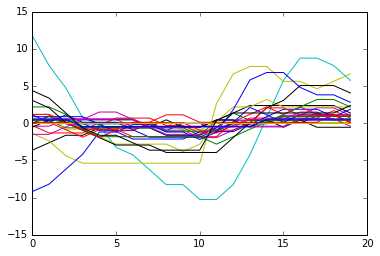

In [15]:
plt.plot(seriesRDD.center().subset(50).T)

In [16]:
# distributed computatino of custom statistics
seriesRDD.apply(lambda x: x.argmin())

Series
nrecords: 13224
dtype: None (inspect to compute)
shape: None (inspect to compute)
dims: (76, 87, 2)
index: None (inspect to compute)